In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#pip install pandas_ta

In [3]:
import pandas_ta as ta

In [4]:
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [5]:
bist_daily = pd.read_csv("datasets/bist_100_daily.csv")
# Extract the number of rows and columns by using the shape of the data.
numRows,numColumns = bist_daily.shape
# Extract the time interval.
last_date, first_date = bist_daily.iloc[0].Date, bist_daily.iloc[-1].Date
# Check the availability of the data.
na_cols = bist_daily.columns[bist_daily.isna().any()].tolist()

# Print the information.
print(f"There are {numRows} rows and {numColumns} columns in the initial dataset.")
print(f"The data represents the time frame between the dates '{last_date}' and '{first_date}'.")
if not na_cols:
    print("There are no NA rows.")
else:
    print(f"Columns in the dataset which include NA rows: {na_cols}.")
# Convert columns to numeric values
column_names = ["Price", "Open", "High", "Low"]
for column in column_names:
    bist_daily[column] = bist_daily[column].str.replace(',', '')
    bist_daily[column] = pd.to_numeric(bist_daily[column])
# CONVERT TO DATETIME FORMAT AND SORT DATA BY DATE
bist_daily.Date = pd.to_datetime(bist_daily.Date)
bist_daily.sort_values(by="Date", ignore_index=True,inplace=True)
bist_daily.set_index(pd.DatetimeIndex(bist_daily["Date"]), inplace=True)
bist_daily.rename(columns={"Price": "close"},inplace=True)
# Calculate Returns and append to the df DataFrame
# CUMLOGRET_1 and CUMPCTRET_1 are added (NaN values exists)
bist_daily.ta.log_return(cumulative=True, append=True)
bist_daily.ta.percent_return(cumulative=True, append=True)
# Returns a list of indicators and utility functions (to check in future)
ind_list = bist_daily.ta.indicators(as_list=True)
# RSI_14, MACD_12_26_9, MACDh_12_26_9 and MACDs_12_26_9 are added (NaN values exists)
bist_daily.ta.rsi(append=True)
bist_daily.ta.macd(append=True)
# SMA values are added (use ta in the future)
sma_values = [5, 10, 15] 
for i in sma_values:
    bist_daily['SMA'+str(i)] = bist_daily['close'].rolling(window=i).mean()
# Remove all NaN value rows
bist_daily.dropna(inplace=True)
bist_daily

There are 5000 rows and 7 columns in the initial dataset.
The data represents the time frame between the dates 'Dec 11, 2019' and 'Jan 04, 2000'.
There are no NA rows.


,date,close,open,high,low,Vol.,Change %,CUMLOGRET_1,CUMPCTRET_1,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA5,SMA10,SMA15
date,,,,,,,,,,,,,,,,
2000-02-21,2000-02-21,145.69,153.64,153.64,142.79,25.75M,-5.17%,-0.183990,-0.160515,34.352566,-7.230371,-0.392050,-6.838321,153.936,155.116,157.896000
2000-02-22,2000-02-22,139.94,145.69,147.02,137.58,29.58M,-3.95%,-0.224258,-0.199983,31.136786,-8.027940,-0.951695,-7.076245,150.206,153.060,156.330667
2000-02-23,2000-02-23,134.47,139.94,141.26,131.71,26.95M,-3.91%,-0.264130,-0.239071,28.411996,-8.997682,-1.537150,-7.460532,145.432,151.074,154.602000
2000-02-24,2000-02-24,146.52,134.47,146.52,134.14,43.02M,8.96%,-0.178310,-0.149460,40.719161,-8.693661,-0.986503,-7.707158,144.052,149.896,153.638667
2000-02-25,2000-02-25,156.18,146.52,156.32,146.52,56.16M,6.59%,-0.114462,-0.083530,48.380526,-7.585796,0.097090,-7.682886,144.560,149.916,152.803333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-05,2019-12-05,1086.59,1082.60,1090.32,1081.51,2.24B,0.89%,1.825328,2.894902,66.153619,16.788401,0.360019,16.428382,1076.116,1068.981,1068.217333
2019-12-06,2019-12-06,1088.69,1090.09,1093.15,1083.52,2.16B,0.19%,1.827259,2.896834,66.774984,17.187282,0.607120,16.580162,1080.046,1071.262,1070.543333
2019-12-09,2019-12-09,1087.86,1088.96,1091.25,1081.39,2.32B,-0.08%,1.826496,2.896072,66.257244,17.237719,0.526046,16.711673,1081.610,1074.666,1071.836667


In [6]:
# edit Vol. column

from operator import itemgetter

vols = bist_daily['Vol.'].to_list()
#[vol[-1] for vol in vols]
#list(filter(lambda vol: "-" in vol,enumerate(vols)))

indexToRemove = bist_daily.iloc[list(map(itemgetter(0),filter(lambda vol: "-" in vol,enumerate(vols))))].index
bist_daily.drop(indexToRemove,inplace=True)
bist_daily['Vol.'] = bist_daily['Vol.'].apply(
    lambda x: float(x[:-1])*(10**6) if x[-1]=="M" else (float(x[:-1])*(10**9) if x[-1]=="B" else "ERROR")).astype("int")
bist_daily

,date,close,open,high,low,Vol.,Change %,CUMLOGRET_1,CUMPCTRET_1,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA5,SMA10,SMA15
date,,,,,,,,,,,,,,,,
2000-02-21,2000-02-21,145.69,153.64,153.64,142.79,25750000,-5.17%,-0.183990,-0.160515,34.352566,-7.230371,-0.392050,-6.838321,153.936,155.116,157.896000
2000-02-22,2000-02-22,139.94,145.69,147.02,137.58,29580000,-3.95%,-0.224258,-0.199983,31.136786,-8.027940,-0.951695,-7.076245,150.206,153.060,156.330667
2000-02-23,2000-02-23,134.47,139.94,141.26,131.71,26950000,-3.91%,-0.264130,-0.239071,28.411996,-8.997682,-1.537150,-7.460532,145.432,151.074,154.602000
2000-02-24,2000-02-24,146.52,134.47,146.52,134.14,43020000,8.96%,-0.178310,-0.149460,40.719161,-8.693661,-0.986503,-7.707158,144.052,149.896,153.638667
2000-02-25,2000-02-25,156.18,146.52,156.32,146.52,56160000,6.59%,-0.114462,-0.083530,48.380526,-7.585796,0.097090,-7.682886,144.560,149.916,152.803333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-05,2019-12-05,1086.59,1082.60,1090.32,1081.51,-2147483648,0.89%,1.825328,2.894902,66.153619,16.788401,0.360019,16.428382,1076.116,1068.981,1068.217333
2019-12-06,2019-12-06,1088.69,1090.09,1093.15,1083.52,-2147483648,0.19%,1.827259,2.896834,66.774984,17.187282,0.607120,16.580162,1080.046,1071.262,1070.543333
2019-12-09,2019-12-09,1087.86,1088.96,1091.25,1081.39,-2147483648,-0.08%,1.826496,2.896072,66.257244,17.237719,0.526046,16.711673,1081.610,1074.666,1071.836667


In [7]:
# seeding an arbitrary number to get same results in multiple runs
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Seed:", manualSeed)

Seed: 999


In [8]:
# getting number of GPUs from cuda
ngpu = torch.cuda.device_count()
print("Count of available GPUs:", ngpu)

Count of available GPUs: 1


In [9]:
# printing the name of available GPUs
for i in range(ngpu):
    print("GPU {}: {}".format(i+1, torch.cuda.get_device_name(i)))

GPU 1: GeForce RTX 2060


In [10]:
# batch size for the training
batch_size = 64

# optimizer rates
optimizer_betas = (0.9, 0.999)
learning_rate = 1e-3

# number of epochs
num_epochs = 100000

# decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [11]:
class TimeseriesDataset(Dataset):
    def __init__(self, data_frame, sequence_length=2):
        self.data = torch.tensor(data_frame.values)
        self.sequence_length = sequence_length

    def __len__(self):
        return self.data.shape[0] - self.sequence_length + 1

    def __getitem__(self, index):
        return self.data[index: index + self.sequence_length].float()
    
    # Non-overlapping series
    # def __getitem__(self, index):
    #     return self.data[index * self.sequence_length: (index+1) * self.sequence_length]

In [12]:
# create pytorch dataset from the pandas DataFrame

# TODO: Convert change(%) and Volume columns to numeric values
columns_used_in_training = ["close", "open", "high", "low", "CUMLOGRET_1", "RSI_14", "MACD_12_26_9", "SMA5"]
# input dimension of the generator
data_dimension = len(columns_used_in_training)
# sequence length of input data
sequence_length = 30

train_data, rest_data = train_test_split(bist_daily[columns_used_in_training], test_size=0.2, shuffle=False)
test_data, validation_data = train_test_split(rest_data, test_size=0.5, shuffle=False)

train_dataset = TimeseriesDataset(train_data, sequence_length)
test_dataset = TimeseriesDataset(test_data, sequence_length)
validation_dataset = TimeseriesDataset(validation_data, sequence_length)

# create the dataloader
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)
real_data_sample = next(iter(train_dataloader))
print("Real data sample shape:", real_data_sample.shape)

Real data sample shape: torch.Size([64, 30, 8])


In [13]:
class Generator(nn.Module):
    def __init__(self, hidden_size):
        super(Generator, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=data_dimension, hidden_size=hidden_size, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_size, data_dimension)
        self.drop = nn.Dropout(0.2)

    def forward(self, input_sequences):
        input_sequences = self.drop(input_sequences)
        lstm_output, hidden_cell = self.lstm(input_sequences)
        res = self.linear(hidden_cell[0][-1])
        res = res.view(res.shape[0], 1, -1)
        return res

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(sequence_length*data_dimension, 72),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(72, 100),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(100, 10),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(10, 1),
            nn.Sigmoid(),
        )

    def forward(self, input_sequences):
        input_sequences_flattened = input_sequences.view(input_sequences.shape[0], -1)
        res = self.model(input_sequences_flattened)
        return res

In [15]:
def model_rmse(model, dataloader, plot_graph=False, plot_title="Validation Predictions"):
    rmse = 0
    squared_error_list = []
    real_data_list = []
    predicted_data_list = []
    for i, sequence_batch in enumerate(dataloader):
        with torch.no_grad():
            real_sequence = sequence_batch
            # Assign first t values
            generator_input_sequence = sequence_batch[:,:-1].to(device)
            real_values = sequence_batch[:,-1:]
            #  Generate (t+1)th value from first t values
            predicted_values = generator(generator_input_sequence).cpu()
            squared_error_list.append((predicted_values - real_values) ** 2)
            real_data_list.append(real_values)
            predicted_data_list.append(predicted_values)
    squared_errors = torch.cat(squared_error_list, 0)
    real_data = torch.cat(real_data_list, 0)
    predicted_data = torch.cat(predicted_data_list, 0)
    if plot_graph:
        # TODO: get x values and plot prediction of multiple columns
        plt.xlabel("Date")
        plt.ylabel("Close Price")
        plt.title(plot_title)
        plt.plot(real_data[:,:,0].view(-1),label="Real")
        plt.plot(predicted_data[:,:,0].view(-1),label="Predicted")
        plt.ylim(bottom=1)
        plt.legend()
        plt.show()
    rmse = np.sqrt(squared_errors.mean())
    return rmse

In [16]:
# TODO: weight initialization of models

In [17]:
generator = Generator(hidden_size=data_dimension*30).to(device)
discriminator = Discriminator().to(device)
print("Generator and discriminator are initialized")

Generator and discriminator are initialized


In [18]:
criterion = nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=optimizer_betas)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=optimizer_betas)

real_label = 1.
fake_label = 0.

In [19]:
if not os.path.exists('./models/'):
    os.makedirs('./models/')

Training is started


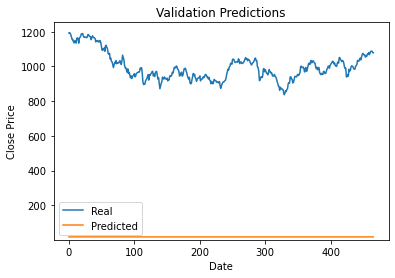


[1/100000]	Discriminator Loss: 0.0852	Generator Loss: 10.6781   	RMSE:777.0216
close | Real:240.4700 / Generated:17.3711
open | Real:253.0200 / Generated:17.7118
high | Real:253.8700 / Generated:16.8833
low | Real:239.4500 / Generated:17.0704
CUMLOGRET_1 | Real:0.3171 / Generated:5.8082
RSI_14 | Real:33.1696 / Generated:16.7741
MACD_12_26_9 | Real:-15.4086 / Generated:1.2633
SMA5 | Real:251.6080 / Generated:19.4211


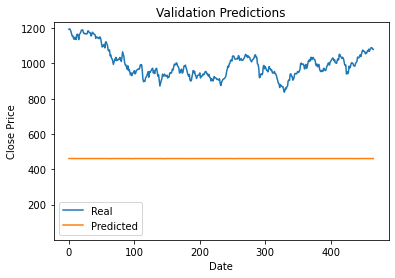


[50/100000]	Discriminator Loss: 0.9568	Generator Loss: 8.0460   	RMSE:425.4602
close | Real:724.4900 / Generated:460.8295
open | Real:723.2500 / Generated:465.3627
high | Real:728.9200 / Generated:467.4880
low | Real:723.2500 / Generated:463.4189
CUMLOGRET_1 | Real:1.4200 / Generated:0.1420
RSI_14 | Real:60.8433 / Generated:25.1971
MACD_12_26_9 | Real:4.3499 / Generated:-11.4211
SMA5 | Real:718.5880 / Generated:468.9475


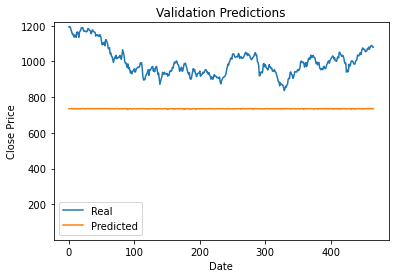


[100/100000]	Discriminator Loss: 0.9620	Generator Loss: 2.5413   	RMSE:217.6474
close | Real:682.2200 / Generated:717.4246
open | Real:678.1100 / Generated:717.7583
high | Real:686.7700 / Generated:720.6686
low | Real:678.1100 / Generated:710.4468
CUMLOGRET_1 | Real:1.3599 / Generated:3.0494
RSI_14 | Real:59.4138 / Generated:21.4091
MACD_12_26_9 | Real:0.7180 / Generated:-11.4328
SMA5 | Real:670.7520 / Generated:717.1594


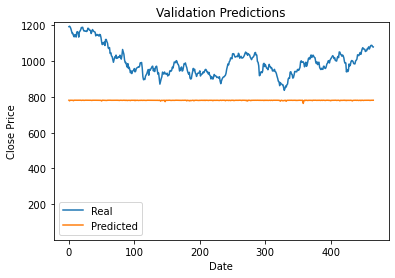


[150/100000]	Discriminator Loss: 1.3150	Generator Loss: 0.7205   	RMSE:187.4767
close | Real:380.8900 / Generated:373.6167
open | Real:374.9500 / Generated:370.5752
high | Real:381.9000 / Generated:372.7285
low | Real:374.9500 / Generated:362.1747
CUMLOGRET_1 | Real:0.7770 / Generated:-3.2871
RSI_14 | Real:76.6509 / Generated:73.4558
MACD_12_26_9 | Real:12.2634 / Generated:8.7862
SMA5 | Real:371.7460 / Generated:366.5017


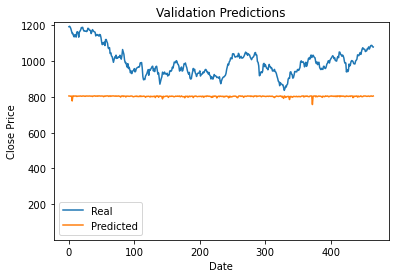


[200/100000]	Discriminator Loss: 1.0399	Generator Loss: 2.2574   	RMSE:168.5733
close | Real:393.9500 / Generated:386.7777
open | Real:390.9600 / Generated:384.5130
high | Real:397.9000 / Generated:389.8744
low | Real:390.4900 / Generated:375.7987
CUMLOGRET_1 | Real:0.8108 / Generated:-1.4230
RSI_14 | Real:72.6409 / Generated:69.3411
MACD_12_26_9 | Real:8.8622 / Generated:1.1551
SMA5 | Real:385.4880 / Generated:380.3881


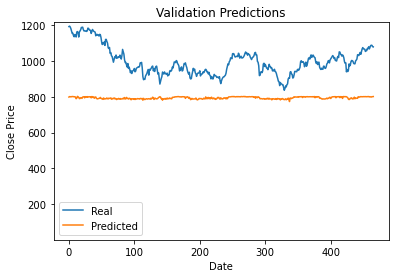


[250/100000]	Discriminator Loss: 1.3069	Generator Loss: 1.2870   	RMSE:169.7119
close | Real:98.0600 / Generated:97.5616
open | Real:96.3000 / Generated:97.3766
high | Real:98.6600 / Generated:100.2168
low | Real:95.8800 / Generated:95.5164
CUMLOGRET_1 | Real:-0.5799 / Generated:0.4191
RSI_14 | Real:50.3158 / Generated:40.7509
MACD_12_26_9 | Real:-0.1181 / Generated:0.3102
SMA5 | Real:97.0600 / Generated:97.3926


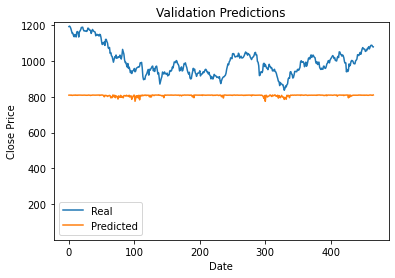


[300/100000]	Discriminator Loss: 1.0802	Generator Loss: 1.2359   	RMSE:158.6783
close | Real:99.1500 / Generated:97.7289
open | Real:98.3300 / Generated:97.7282
high | Real:99.3600 / Generated:100.5938
low | Real:97.3000 / Generated:96.2018
CUMLOGRET_1 | Real:-0.5688 / Generated:-0.0520
RSI_14 | Real:48.1547 / Generated:44.5294
MACD_12_26_9 | Real:-2.5138 / Generated:0.4108
SMA5 | Real:97.8100 / Generated:98.0035


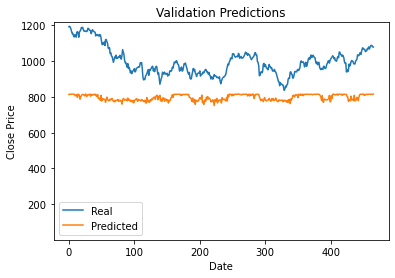


[350/100000]	Discriminator Loss: 1.2629	Generator Loss: 1.1960   	RMSE:163.7410
close | Real:740.3200 / Generated:763.0569
open | Real:742.7100 / Generated:770.3702
high | Real:744.9800 / Generated:777.6514
low | Real:737.3300 / Generated:764.2153
CUMLOGRET_1 | Real:1.4416 / Generated:5.9598
RSI_14 | Real:46.8123 / Generated:6.7500
MACD_12_26_9 | Real:-6.4908 / Generated:-4.0230
SMA5 | Real:738.2680 / Generated:775.0742


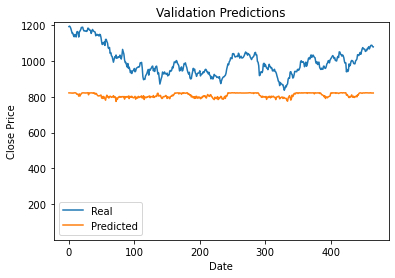


[400/100000]	Discriminator Loss: 0.8255	Generator Loss: 5.6657   	RMSE:156.1590
close | Real:282.0200 / Generated:278.3807
open | Real:278.1300 / Generated:279.0633
high | Real:284.0300 / Generated:282.9396
low | Real:278.1300 / Generated:275.3372
CUMLOGRET_1 | Real:0.4765 / Generated:-1.2121
RSI_14 | Real:72.3620 / Generated:74.1574
MACD_12_26_9 | Real:8.4379 / Generated:3.9534
SMA5 | Real:278.7140 / Generated:280.8015


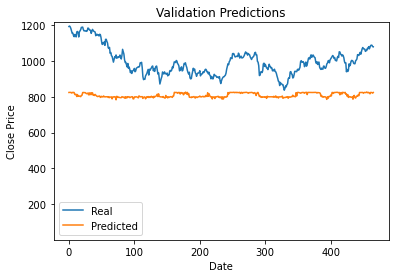


[450/100000]	Discriminator Loss: 1.3323	Generator Loss: 0.8561   	RMSE:158.8377
close | Real:823.0300 / Generated:798.9871
open | Real:828.3100 / Generated:803.5720
high | Real:830.7800 / Generated:805.2261
low | Real:821.6800 / Generated:796.0192
CUMLOGRET_1 | Real:1.5475 / Generated:10.5951
RSI_14 | Real:50.2509 / Generated:6.9915
MACD_12_26_9 | Real:0.0893 / Generated:-1.2297
SMA5 | Real:821.6720 / Generated:807.6093


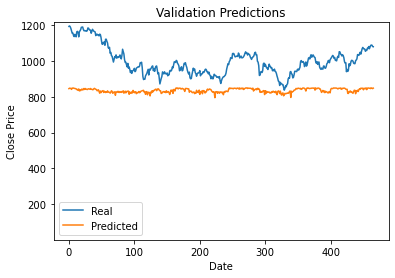


[500/100000]	Discriminator Loss: 1.0245	Generator Loss: 1.1902   	RMSE:141.5035
close | Real:782.7700 / Generated:803.2949
open | Real:782.5800 / Generated:806.3931
high | Real:788.6000 / Generated:805.9012
low | Real:766.5700 / Generated:797.7426
CUMLOGRET_1 | Real:1.4974 / Generated:5.7132
RSI_14 | Real:27.5101 / Generated:16.4381
MACD_12_26_9 | Real:-19.2301 / Generated:-4.3097
SMA5 | Real:795.9780 / Generated:806.2673


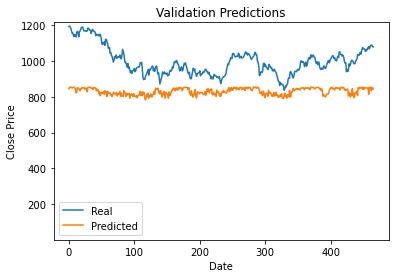


[550/100000]	Discriminator Loss: 1.1306	Generator Loss: 3.0890   	RMSE:143.5443
close | Real:256.1000 / Generated:259.1318
open | Real:257.2500 / Generated:259.2868
high | Real:257.3000 / Generated:261.2788
low | Real:255.2200 / Generated:255.0230
CUMLOGRET_1 | Real:0.3801 / Generated:0.5760
RSI_14 | Real:55.7715 / Generated:60.5177
MACD_12_26_9 | Real:2.4731 / Generated:0.2199
SMA5 | Real:256.1860 / Generated:258.2310


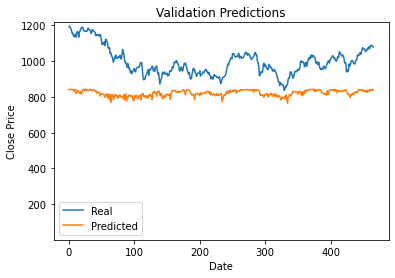


[600/100000]	Discriminator Loss: 1.6066	Generator Loss: 0.9046   	RMSE:150.8940
close | Real:116.7500 / Generated:117.5050
open | Real:112.5500 / Generated:116.9691
high | Real:116.7500 / Generated:119.4189
low | Real:112.2800 / Generated:114.9119
CUMLOGRET_1 | Real:-0.4054 / Generated:-0.8573
RSI_14 | Real:38.1361 / Generated:41.4553
MACD_12_26_9 | Real:-2.9859 / Generated:-4.0135
SMA5 | Real:118.8200 / Generated:116.9118


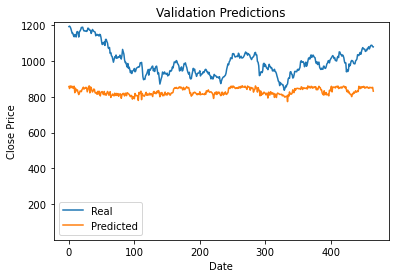


[650/100000]	Discriminator Loss: 1.2053	Generator Loss: 1.5478   	RMSE:144.1795
close | Real:511.1200 / Generated:514.6068
open | Real:516.4400 / Generated:515.6977
high | Real:516.4400 / Generated:517.6893
low | Real:507.8400 / Generated:506.6002
CUMLOGRET_1 | Real:1.0711 / Generated:-0.8499
RSI_14 | Real:64.8753 / Generated:72.4953
MACD_12_26_9 | Real:15.1899 / Generated:11.7652
SMA5 | Real:517.2460 / Generated:510.5437


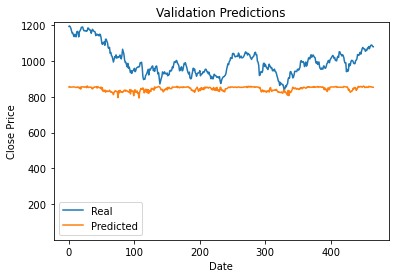


[700/100000]	Discriminator Loss: 1.2655	Generator Loss: 1.2678   	RMSE:134.8060
close | Real:276.8900 / Generated:280.7401
open | Real:278.0800 / Generated:281.1082
high | Real:279.2000 / Generated:285.7052
low | Real:275.7300 / Generated:276.1547
CUMLOGRET_1 | Real:0.4581 / Generated:1.7777
RSI_14 | Real:64.2974 / Generated:62.8191
MACD_12_26_9 | Real:5.5725 / Generated:8.3479
SMA5 | Real:277.6180 / Generated:279.4895


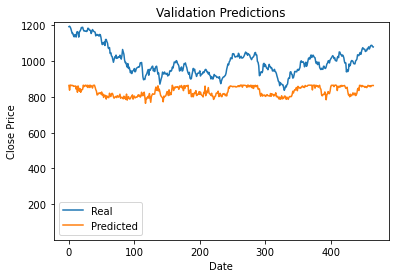


[750/100000]	Discriminator Loss: 0.9572	Generator Loss: 3.6831   	RMSE:142.1008
close | Real:641.8700 / Generated:649.6486
open | Real:633.2000 / Generated:650.8538
high | Real:641.8700 / Generated:657.6357
low | Real:633.0500 / Generated:641.2684
CUMLOGRET_1 | Real:1.2989 / Generated:-0.4348
RSI_14 | Real:57.5336 / Generated:38.6026
MACD_12_26_9 | Real:-2.2372 / Generated:-3.4169
SMA5 | Real:633.0860 / Generated:648.4951


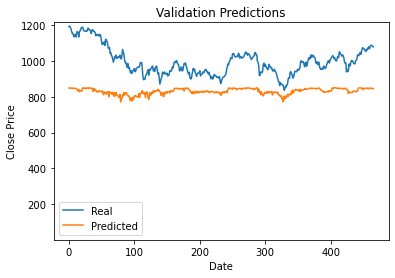


[800/100000]	Discriminator Loss: 1.0963	Generator Loss: 1.6112   	RMSE:141.8337
close | Real:839.7100 / Generated:824.1504
open | Real:830.4700 / Generated:827.9803
high | Real:840.0300 / Generated:835.3049
low | Real:828.6800 / Generated:814.3799
CUMLOGRET_1 | Real:1.5676 / Generated:3.3025
RSI_14 | Real:63.7884 / Generated:54.3258
MACD_12_26_9 | Real:8.9614 / Generated:9.0066
SMA5 | Real:827.4480 / Generated:827.9916


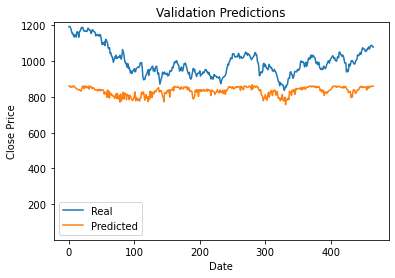


[850/100000]	Discriminator Loss: 1.0997	Generator Loss: 1.2045   	RMSE:138.4495
close | Real:264.9300 / Generated:244.6822
open | Real:262.7100 / Generated:245.5267
high | Real:265.6600 / Generated:252.1151
low | Real:260.8200 / Generated:242.3843
CUMLOGRET_1 | Real:0.4140 / Generated:0.6098
RSI_14 | Real:72.8758 / Generated:56.1097
MACD_12_26_9 | Real:7.1480 / Generated:3.5436
SMA5 | Real:259.5740 / Generated:248.3301


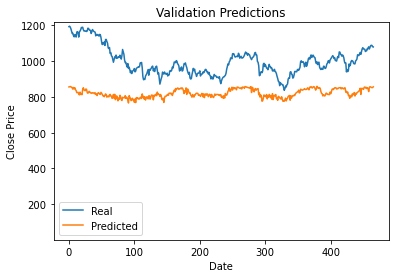


[900/100000]	Discriminator Loss: 0.9543	Generator Loss: 2.1098   	RMSE:147.3927
close | Real:104.6400 / Generated:105.0586
open | Real:105.4400 / Generated:103.8379
high | Real:105.4400 / Generated:108.8049
low | Real:103.5900 / Generated:103.8124
CUMLOGRET_1 | Real:-0.5149 / Generated:-0.8645
RSI_14 | Real:42.6381 / Generated:49.9356
MACD_12_26_9 | Real:-0.4743 / Generated:-1.7639
SMA5 | Real:106.8860 / Generated:105.9329


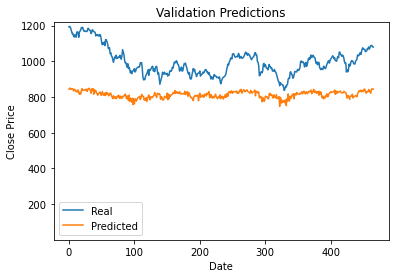


[950/100000]	Discriminator Loss: 1.0327	Generator Loss: 2.7982   	RMSE:151.0392
close | Real:555.2600 / Generated:547.1898
open | Real:547.3100 / Generated:549.9779
high | Real:555.2600 / Generated:552.8071
low | Real:544.9200 / Generated:543.3940
CUMLOGRET_1 | Real:1.1540 / Generated:0.9141
RSI_14 | Real:64.4996 / Generated:71.5901
MACD_12_26_9 | Real:8.3624 / Generated:4.4704
SMA5 | Real:546.6700 / Generated:550.0783


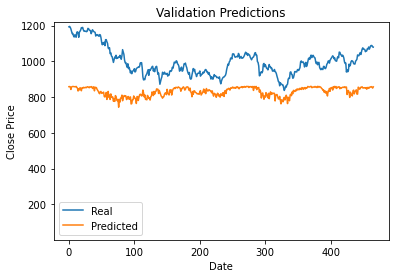


[1000/100000]	Discriminator Loss: 1.3434	Generator Loss: 0.6683   	RMSE:140.0273
close | Real:92.8200 / Generated:92.5232
open | Real:93.2500 / Generated:90.7314
high | Real:93.8700 / Generated:94.5033
low | Real:92.1200 / Generated:91.5365
CUMLOGRET_1 | Real:-0.6348 / Generated:-1.3020
RSI_14 | Real:45.1657 / Generated:47.3908
MACD_12_26_9 | Real:-1.3671 / Generated:-1.7148
SMA5 | Real:92.7080 / Generated:92.1550


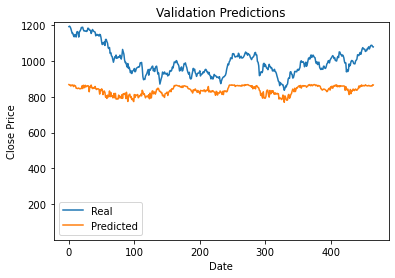


[1050/100000]	Discriminator Loss: 1.2777	Generator Loss: 0.8027   	RMSE:137.2937
close | Real:157.5400 / Generated:140.6537
open | Real:153.8000 / Generated:138.5876
high | Real:157.7600 / Generated:142.4642
low | Real:153.8000 / Generated:138.1103
CUMLOGRET_1 | Real:-0.1058 / Generated:-0.8425
RSI_14 | Real:63.9152 / Generated:54.6890
MACD_12_26_9 | Real:4.2462 / Generated:2.0686
SMA5 | Real:150.4760 / Generated:139.4025


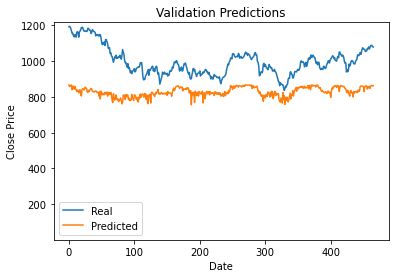


[1100/100000]	Discriminator Loss: 1.2423	Generator Loss: 0.7092   	RMSE:144.3795
close | Real:102.9200 / Generated:96.8317
open | Real:100.7000 / Generated:93.5151
high | Real:103.1000 / Generated:97.5260
low | Real:98.6400 / Generated:93.9794
CUMLOGRET_1 | Real:-0.5315 / Generated:-0.6422
RSI_14 | Real:69.4908 / Generated:54.4851
MACD_12_26_9 | Real:4.5450 / Generated:2.7228
SMA5 | Real:99.5320 / Generated:93.6900


KeyboardInterrupt: 

In [20]:
evaluation_metrics = {"gen_loss":[], "disc_loss":[], "rmse":[]}
                      
print("Training is started")
for epoch in range(num_epochs):
    for i, sequence_batch in enumerate(train_dataloader):
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Training with real batch
            discriminator.zero_grad()
            # Format batch
            real_sequence = sequence_batch.to(device)
            batch_size = real_sequence.size(0)
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            discriminator_output_real = discriminator(real_sequence).view(-1)
            # Calculate loss on all-real batch
            discriminator_error_real = criterion(discriminator_output_real, real_labels)
            # Calculate gradients for D in backward pass
            discriminator_error_real.backward()

            ## Training with fake batch
            # Assign first t values
            generator_input_sequence = sequence_batch[:,:-1].to(device)
            #  Generate (t+1)th value from first t values
            generated_values = generator(generator_input_sequence)
            fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
            # Concat first t real values and generated (t+1)th values
            generator_result_concat = torch.cat((generator_input_sequence, generated_values.detach()), 1)
            # Classify all fake batch with D
            discriminator_output_fake = discriminator(generator_result_concat).view(-1)
            # Calculate D's loss on the all-fake batch
            discriminator_error_fake = criterion(discriminator_output_fake, fake_labels)
            # Calculate the gradients for this batch
            discriminator_error_fake.backward()
            # Add the gradients from the all-real and all-fake batches
            discriminator_error = discriminator_error_real + discriminator_error_fake
            # Update D
            optimizer_discriminator.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            generator.zero_grad()
            real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            # Since we just updated D, perform another forward pass of all-fake batch through D
            generator_result_concat_grad = torch.cat((generator_input_sequence, generated_values), 1)
            discriminator_output_fake = discriminator(generator_result_concat_grad).view(-1)
            # Calculate G's loss based on this output
            generator_error = criterion(discriminator_output_fake, real_labels)
            # Calculate gradients for G
            generator_error.backward()
            # Update G
            optimizer_generator.step()
    if (epoch+1) % 50 == 0 or epoch+1 == 1:
        rmse = model_rmse(generator, validation_dataloader, plot_graph=True)
        evaluation_metrics["rmse"].append(rmse)
        evaluation_metrics["gen_loss"].append(generator_error.item())
        evaluation_metrics["disc_loss"].append(discriminator_error.item())
        print('\n[{}/{}]\tDiscriminator Loss: {:.4f}\tGenerator Loss: {:.4f}   \tRMSE:{:.4f}'
                  .format(epoch+1, num_epochs, discriminator_error.item(), generator_error.item(), rmse))
        for col_name, real, generated in zip(columns_used_in_training, sequence_batch[0][-1], generated_values[0][0]):
            print(f"{col_name} | Real:{real:.4f} / Generated:{generated:.4f}")
        save_path = os.path.join("./models/","model_epoch_{}.pt".format(epoch+1))
        torch.save({
            'epoch': epoch+1,
            'generator_model_state_dict': generator.state_dict(),
            'discriminator_model_state_dict': discriminator.state_dict(),
            'optimizer_generator_state_dict': optimizer_generator.state_dict(),
            'optimizer_discriminator_state_dict': optimizer_discriminator.state_dict(),
            'discriminator_loss': discriminator_error,
            'generator_loss': generator_error,
            }, save_path)